In [4]:
import georinex as gr
import numpy
import math
import wget
import os

In [3]:
#Going to download station COLB in Columbus on day 200 of this year
#uncomment the next three lines if you dont have the file
#url = "https://noaa-cors-pds.s3.amazonaws.com/rinex/2025/200/colb/colb2000.25o.gz"
#wget.download(url)
#os.system('gunzip' + ' colb2000.25o.gz')

100% [..........................................................................] 2893758 / 2893758

'colb2000.25o.gz'

In [7]:
header=gr.rinexheader('colb2000.25o')
print(header) #printing header information
#This specific file has L1, L2, L5, C1, P1, C2, P2, C5

{'version': 2.11, 'filetype': 'O', 'rinextype': 'obs', 'systems': 'M', 'PGM / RUN BY / DATE': 'teqc  2019Feb25     CORS-ADM Account    20250820 12:33:56UTC', 'COMMENT': 'Linux 2.4.21-27.ELsmp|Opteron|gcc|Linux 64|=+                teqc  2019Feb25     NOAA/NOS/NGS/CORS   20250720 00:15:13UTC +39.959753481 (latitude)                                     -083.04576306 (longitude)                                    +186.442      (elevation)                                    +.000000      (antenna height)                               BIT 2 OF LLI FLAGS DATA COLLECTED UNDER A/S CONDITION         SNR is mapped to RINEX snr flag value [0-9]                   L1 & L2: min(max(int(snr_dBHz/6), 0), 9)                   teqc.e windowed: start @ 2025 Jul 19 00:00:00.000            teqc.e windowed: delta = 86400.000 sec                       teqc.e edited: all SBAS satellites excluded                  teqc.e edited: all QZSS satellites excluded                  Forced Modulo Decimation to 30 second

In [8]:
#Load the observables:
obs = gr.load('colb2000.25o')

In [17]:
L1 = obs['L1'].values#phase values
L2 = obs['L2'].values
C1 = obs['C1'].values
C2 = obs['C2'].values
svs = obs.sv #satellites observed
ns = len(svs) #number of satellites observed
obs_time = obs.time.values #observation times
nt = len(obs_time) #number of observation times

In [18]:
print(svs)

<xarray.DataArray 'sv' (sv: 83)>
array(['E02', 'E03', 'E04', 'E05', 'E06', 'E07', 'E08', 'E09', 'E10', 'E11',
       'E12', 'E13', 'E15', 'E16', 'E19', 'E21', 'E23', 'E24', 'E25', 'E26',
       'E27', 'E29', 'E30', 'E31', 'E33', 'E34', 'E36', 'G01', 'G02', 'G03',
       'G04', 'G05', 'G06', 'G07', 'G08', 'G09', 'G10', 'G11', 'G12', 'G13',
       'G14', 'G15', 'G16', 'G17', 'G18', 'G19', 'G20', 'G21', 'G22', 'G23',
       'G24', 'G25', 'G26', 'G27', 'G28', 'G29', 'G30', 'G31', 'G32', 'R01',
       'R02', 'R03', 'R04', 'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'R11',
       'R12', 'R13', 'R14', 'R15', 'R16', 'R17', 'R18', 'R19', 'R20', 'R21',
       'R22', 'R23', 'R24'], dtype='<U3')
Coordinates:
  * sv       (sv) <U3 'E02' 'E03' 'E04' 'E05' 'E06' ... 'R21' 'R22' 'R23' 'R24'


In [19]:
#Print the array shape, number of satellites, number of time points
print(numpy.shape(L1),ns,nt)

(2880, 83) 83 2880


In [20]:
#Find which satellite is G01
a1 = numpy.where(svs.sv == 'G01')[0]
print(a1)

[27]


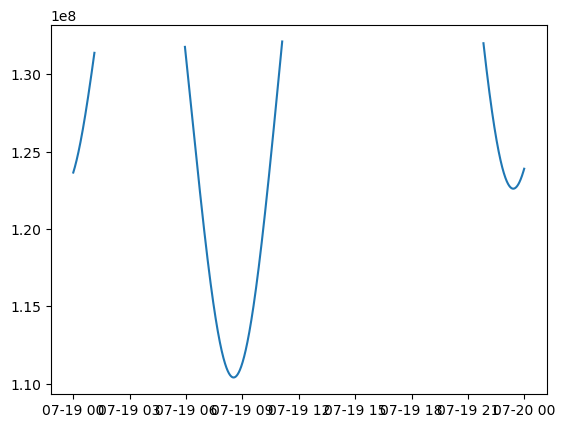

In [21]:
import matplotlib.pylab as plt
#Plot the L1 values for G01, this is in cycles
plt.plot(obs_time,L1[:,a1])

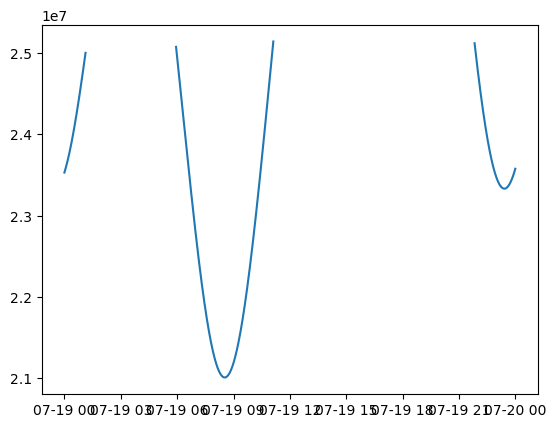

In [22]:
#Plot the C1 values for G01, this is in meters
plt.plot(obs_time,C1[:,a1])

In [23]:
#Some coefficients for frequency and wavelength
c = 299792458.0 #speed of light
fL1 = 1575.42e6 #L1 frequency
fL2 = 1227.60e6 #L2 frequency
wL1 = c/fL1 #L1 wavelength
wL2 = c/fL2 #L2 wavelength

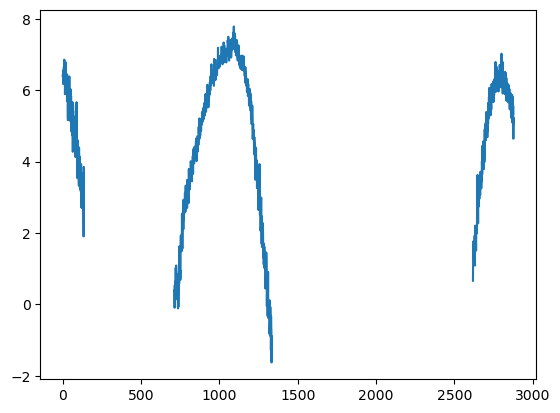

In [39]:
#Lets take L1 minus C1 in meters
plt.plot(L1[:,a1]*wL1-C1[:,a1])

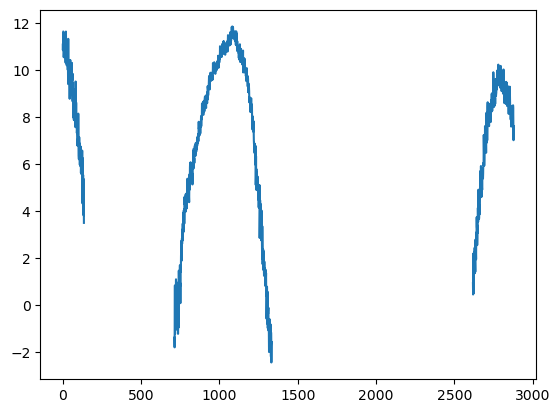

In [40]:
#Lets do the same thing for L2 and C2
plt.plot(L2[:,a1]*wL2-C2[:,a1])

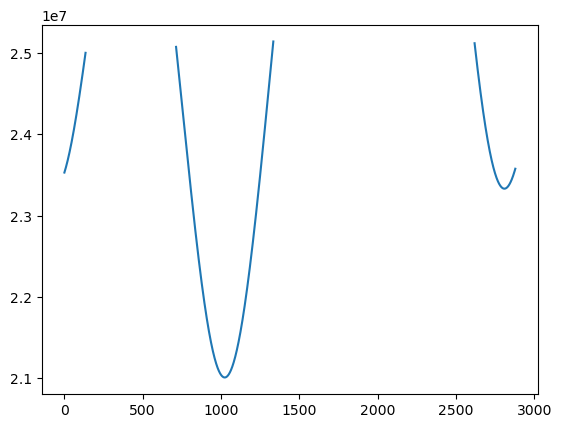

In [41]:
#Note that there is a bit of a difference with the absolute values. The ionosphere, the DCBs and the phase ambiguities could all contribute
#Now lets take the ionosphere free phase combination and plot that
LC = 2.546*L1[:,a1]*wL1-1.546*L2[:,a1]*wL2
plt.plot(LC)

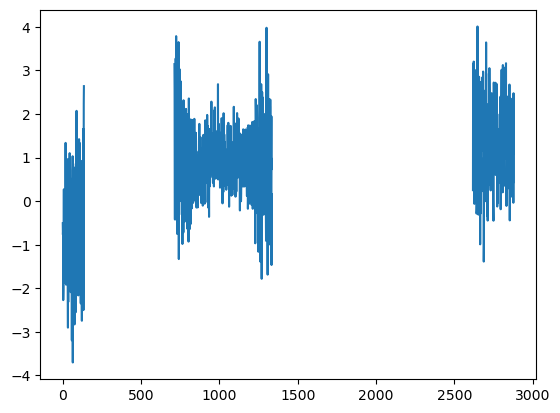

In [42]:
#lets subtract PC here:
PC = 2.546*C1[:,a1]-1.546*C2[:,a1]
plt.plot(LC-PC)

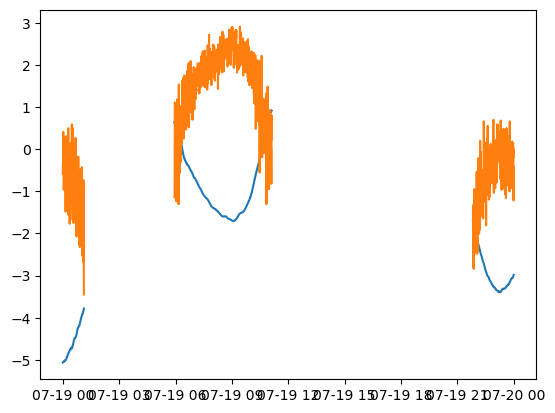

In [32]:
#Note now how the arc lengths have been removed from the examples that used L2-C2 and L1-C1
#Lets now compute the geometry free combination for phase and pseudorange
LG = L1[:,a1]*wL1-L2[:,a1]*wL2
PG = C1[:,a1]-C2[:,a1]
plt.plot(obs_time,LG,obs_time,PG)

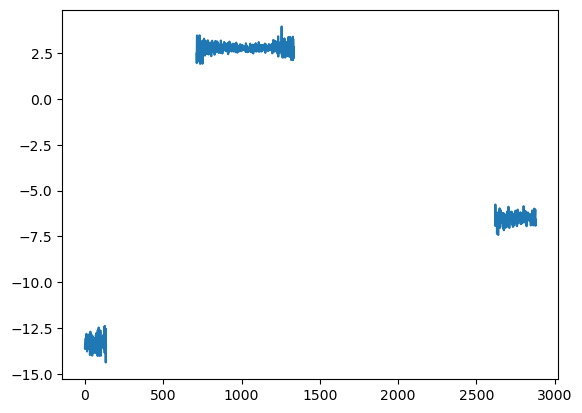

In [43]:
#Notice how the shapes are inverted here given the different signs of the ionosphere components on phase versus code
#There is still a bias though due to the differential code biases
#Lets now attempt the Melbourne Wubbena Wide Lane
MWWL = L1[:,a1]-L2[:,a1]-(fL1-fL2)/(fL1+fL2)*(C1[:,a1]/wL1+C2[:,a1]/wL2)
plt.plot(MWWL)

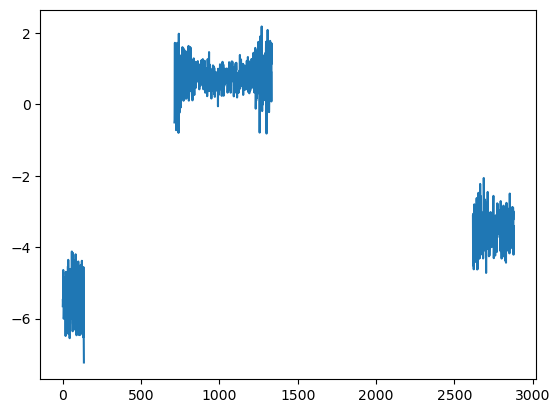

In [51]:
#The above is showing the N2-N1 ambiguity
#Without computing the true ranges, the segregation of N2 and N1 is difficult.
# The general trend though is evident with the LG combination starting low, then going high, then ending in the middle.
#If we use PG to subtract off the ionosphere from LG, we can get at an ambiguity term that is:
#wL1*N1-wL2*N2
plt.plot(LG+PG)

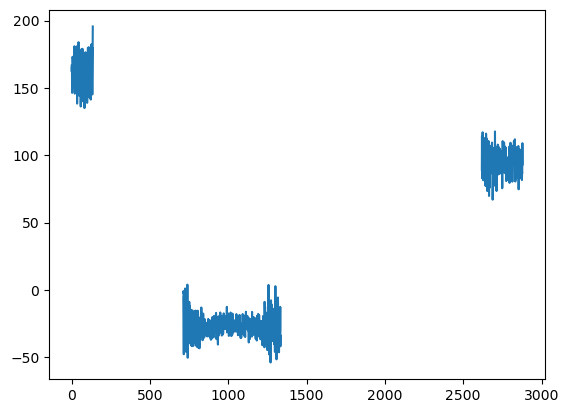

In [52]:
#Theoretically, N1 should be ((LG+PG)+wL2*MWWL)/(wL1-wL2)
N1 = ((LG+PG)+wL2*MWWL)/(wL1-wL2)
plt.plot(N1)

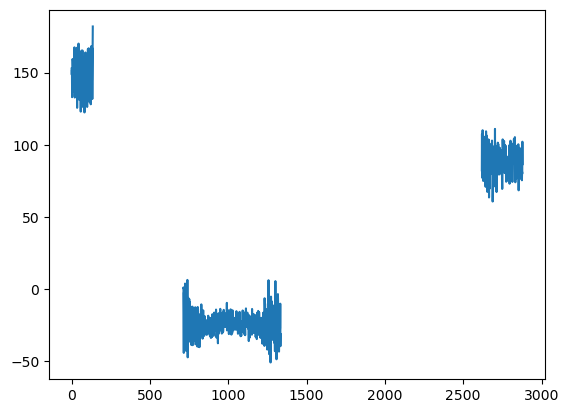

In [53]:
# then N2 comes from MWWL
N2 = MWWL+N1
plt.plot(N2)

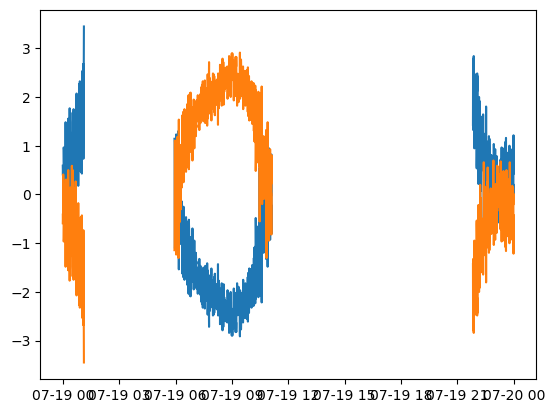

In [55]:
#so lets reformulate LG

LG2 = (L1[:,a1]-N1)*wL1-(L2[:,a1]-N2)*wL2
plt.plot(obs_time,LG2,obs_time,PG)

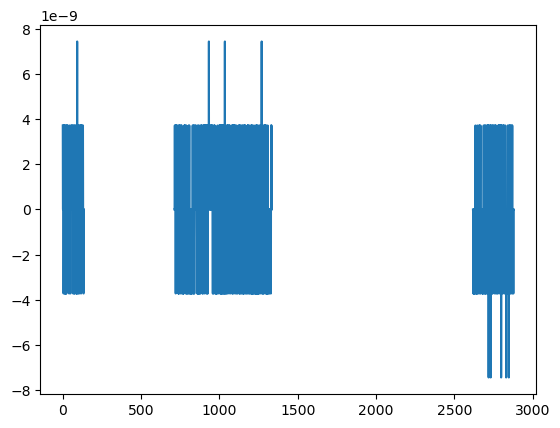

In [57]:
#The symmetry is now more pronounced. Lets add these together
plt.plot(LG2+PG)

In [ ]:
#They are now identical because I used the direct ambiguity float as the true answer. In practice, you would need to round
# your N1 and N2 values since there is signal embedded in there.
#There is still a differential code bias that I have not attempted to estimate. If you have the true range, you can use an average of the residual 
#between C1 and C2